<a href="https://colab.research.google.com/github/yehezkielgunawan/thesis-risk-classification/blob/main/RF_Classification_Indo_BERT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install transformers
!pip install joblib

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.7/7.7 MB 42.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 295.0/295.0 kB 25.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.8/3.8 MB 71.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 54.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 21.6 MB/s eta 0:00:00


In [2]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [3]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns


# Load the new dataset for sentiment classification
new_data = pd.read_excel('/content/gdrive/My Drive/Tesis/Compiled Classification Dataset.xlsx')
new_data.head(5)

,Unnamed: 0,content,priority_score,problem_domain
0,1,"Sorry, including the expensive price + apk usi...",2,0
1,2,Setelah install terus pas buka aplikasi ngebla...,3,1
2,3,"gak bisa submit pada saat verifikasi data, pad...",3,1
3,4,Aplilasi restart mulu,3,1
4,5,"udah mahal , makanan ga enak, banyak lalat",2,0


In [4]:
# Check the label distributions
priority_score_distribution = new_data['priority_score'].value_counts()
problem_domain_distribution = new_data['problem_domain'].value_counts()

print("Label priority_score Distribution:")
print(priority_score_distribution)

print("Label problem_domain Distribution:")
print(problem_domain_distribution)

Label priority_score Distribution:
3    277
2    275
1    148
Name: priority_score, dtype: int64
Label problem_domain Distribution:
0    570
1    130
Name: problem_domain, dtype: int64


In [5]:
sentences = new_data['content'].tolist()

In [6]:
%%time
import torch
from transformers import AutoTokenizer, AutoModel

# Load IndoBERT tokenizer
tokenizer = AutoTokenizer.from_pretrained("indolem/indobert-base-uncased")

# Load IndoBERT model
model = AutoModel.from_pretrained("indolem/indobert-base-uncased")

# Convert the sentences into input features
encoded_inputs = tokenizer(sentences, padding=True, truncation=True, max_length=128, return_tensors="pt")

# Perform word embedding using IndoBERT model
with torch.no_grad():
    outputs = model(**encoded_inputs)
    embeddings = outputs.last_hidden_state

# Convert the embeddings to numpy array
embeddings = embeddings.numpy()

CPU times: user 5min 15s, sys: 1min 1s, total: 6min 16s
Wall time: 6min 48s


In [7]:
# Assuming the labels for the new dataset are stored in two columns
priority_score = new_data['priority_score']
problem_domain = new_data['problem_domain']

# # Reshape the embeddings array
# num_samples = len(embeddings)
# num_features = embeddings.shape[1] * embeddings.shape[2]
# reshaped_embeddings = embeddings.reshape(num_samples, num_features)

# Split the reshaped embeddings into training and testing sets for label 1
X_train1, X_test1, y_train1, y_test1 = train_test_split(embeddings, priority_score, test_size=0.3, random_state=42)

# Split the reshaped embeddings into training and testing sets for label 2
X_train2, X_test2, y_train2, y_test2 = train_test_split(embeddings, problem_domain, test_size=0.3, random_state=42)

# Calculate mean embeddings for priority_score training set
mean_train_embeddings1 = np.mean(X_train1, axis=1)

# Calculate mean embeddings for priority_score testing set
mean_test_embeddings1 = np.mean(X_test1, axis=1)

# Calculate mean embeddings for problem_domain training set
mean_train_embeddings2 = np.mean(X_train2, axis=1)

# Calculate mean embeddings for problem_domain testing set
mean_test_embeddings2 = np.mean(X_test2, axis=1)

# Flatten the mean embeddings to a 2D array
X_train_flat1 = mean_train_embeddings1.reshape(mean_train_embeddings1.shape[0], -1)
X_test_flat1 = mean_test_embeddings1.reshape(mean_test_embeddings1.shape[0], -1)
X_train_flat2 = mean_train_embeddings2.reshape(mean_train_embeddings2.shape[0], -1)
X_test_flat2 = mean_test_embeddings2.reshape(mean_test_embeddings2.shape[0], -1)


In [8]:
%%time
# Define the parameter grid for Grid Search for priority_score
param_grid1 = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 5, 12],
    'min_samples_split': [5, 7, 10]
}

# Define the parameter grid for Grid Search for problem_domain
param_grid2 = {
    'n_estimators': [25, 75, 125],
    'max_depth': [None, 5, 12],
    'min_samples_split': [2, 5, 10]
}

# Initialize the Random Forest classifiers
rf_classifier1 = RandomForestClassifier(class_weight="balanced", random_state=42)
rf_classifier2 = RandomForestClassifier(class_weight="balanced", random_state=42)

# Perform Grid Search to find the best hyperparameters for priority_score
grid_search1 = GridSearchCV(estimator=rf_classifier1, param_grid=param_grid1, cv=5)
grid_search1.fit(X_train_flat1, y_train1)

# Perform Grid Search to find the best hyperparameters for problem_domain
grid_search2 = GridSearchCV(estimator=rf_classifier2, param_grid=param_grid2, cv=5)
grid_search2.fit(X_train_flat2, y_train2)

# Get the best classifiers with the optimal hyperparameters
best_classifier1 = grid_search1.best_estimator_
best_classifier2 = grid_search2.best_estimator_

# Evaluate the best classifiers on the test sets for priority_score
y_pred1 = best_classifier1.predict(X_test_flat1)
classification_rep1 = classification_report(y_test1, y_pred1)

# Evaluate the best classifiers on the test sets for problem_domain
y_pred2 = best_classifier2.predict(X_test_flat2)
classification_rep2 = classification_report(y_test2, y_pred2)

print("Best Hyperparameters for priority_score:", grid_search1.best_params_)
print("Classification Report for priority_score:")
print(classification_rep1)

print("Best Hyperparameters for problem_domain:", grid_search2.best_params_)
print("Classification Report for problem_domain:")
print(classification_rep2)

Best Hyperparameters for priority_score: {'max_depth': 12, 'min_samples_split': 5, 'n_estimators': 100}
Classification Report for priority_score:
              precision    recall  f1-score   support

           1       0.38      0.13      0.19        39
           2       0.38      0.49      0.43        80
           3       0.46      0.48      0.47        91

    accuracy                           0.42       210
   macro avg       0.41      0.37      0.36       210
weighted avg       0.42      0.42      0.40       210

Best Hyperparameters for problem_domain: {'max_depth': 5, 'min_samples_split': 2, 'n_estimators': 75}
Classification Report for problem_domain:
              precision    recall  f1-score   support

           0       0.85      0.99      0.92       172
           1       0.89      0.21      0.34        38

    accuracy                           0.85       210
   macro avg       0.87      0.60      0.63       210
weighted avg       0.86      0.85      0.81       210

CP

In [9]:
# Function to plot confusion matrix
def plot_confusion_matrix_3x3(cm, title):
    plt.figure(figsize=(6, 6))
    sns.heatmap(cm, annot=True, fmt=".0f", cmap='Blues', xticklabels=[1,2,3], yticklabels=[1,2,3])
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title(title)
    plt.show()

def plot_confusion_matrix_2x2(cm, title):
    plt.figure(figsize=(2, 2))
    sns.heatmap(cm, annot=True, fmt=".0f", cmap='Blues')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title(title)
    plt.show()

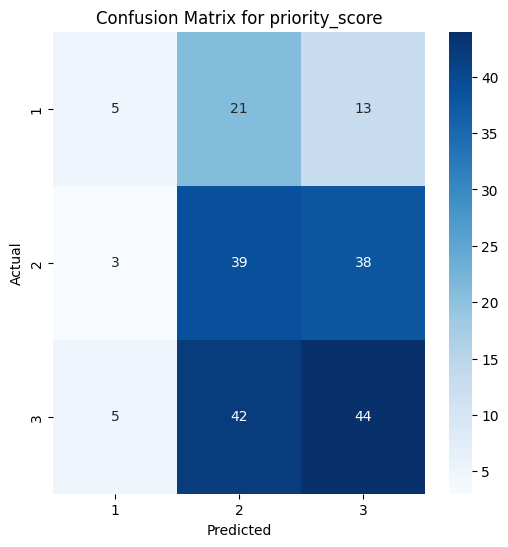

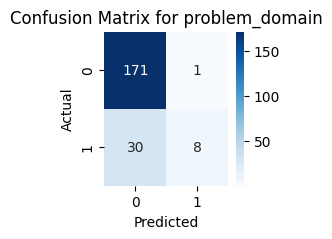

In [10]:
# Calculate confusion matrix for Label 1
cm1 = confusion_matrix(y_test1, y_pred1)

# Plot confusion matrix for Label 1
plot_confusion_matrix_3x3(cm1, title="Confusion Matrix for priority_score")

# Calculate confusion matrix for Label 2
cm2 = confusion_matrix(y_test2, y_pred2)

# Plot confusion matrix for Label 2
plot_confusion_matrix_2x2(cm2, title="Confusion Matrix for problem_domain")

In [11]:
# ... (rest of the code remains the same)

# Get the top words for each label in priority_score
top_words_by_label1 = {}
for label_idx, label in enumerate(set(priority_score)):
    # Filter the test data for the current label
    mask = y_test1 == label
    X_test1_label = X_test_flat1[mask]

    # Get the predicted probabilities for the current label
    y_probs_label = best_classifier1.predict_proba(X_test1_label)

    # Get the importance scores for each word in the sequences
    importance_scores = np.max(y_probs_label, axis=1)

    # Sort the sequences based on importance scores
    sorted_indices = np.argsort(importance_scores)[::-1]

    # Get the corresponding words from the tokenizer (excluding padding tokens and special tokens)
    top_words = [tokenizer.decode(encoded_inputs["input_ids"][idx][encoded_inputs["attention_mask"][idx] == 1][1:-1])
                 for idx in sorted_indices[:3]]

    # Save the top words for the current label
    top_words_by_label1[label] = top_words

# Get the top words for each label in problem_domain
top_words_by_label2 = {}
for label_idx, label in enumerate(set(problem_domain)):
    # Filter the test data for the current label
    mask = y_test2 == label
    X_test2_label = X_test_flat2[mask]

    # Get the predicted probabilities for the current label
    y_probs_label = best_classifier2.predict_proba(X_test2_label)

    # Get the importance scores for each word in the sequences
    importance_scores = np.max(y_probs_label, axis=1)

    # Sort the sequences based on importance scores
    sorted_indices = np.argsort(importance_scores)[::-1]

    # Get the corresponding words from the tokenizer (excluding padding tokens and special tokens)
    top_words = [tokenizer.decode(encoded_inputs["input_ids"][idx][encoded_inputs["attention_mask"][idx] == 1][1:-1])
                 for idx in sorted_indices[:3]]

    # Save the top words for the current label
    top_words_by_label2[label] = top_words

# Print the top words for each label in priority_score
print("Top words for each label in priority_score:")
for label, top_words in top_words_by_label1.items():
    print(f"Label {label}: {top_words}")

# Print the top words for each label in problem_domain
print("Top words for each label in problem_domain:")
for label, top_words in top_words_by_label2.items():
    print(f"Label {label}: {top_words}")

# Top words for each label in priority_score
priority_score_table = {}
for label, top_words in top_words_by_label1.items():
    priority_score_table[label] = ', '.join(top_words)

priority_score_table = pd.DataFrame(priority_score_table, index=['Top Words']).transpose()
priority_score_table.index.name = 'Label'

Top words for each label in priority_score:
Label 1: ['pelayanan resepsionis bobobox pancoran sangat mengecewakan, padahal cwo tapi judes ngomongnya nyolot. buat hotel sebagus ini tolong cari karyawan yg ramah yg bisa melayani tamu dengan baik', 'sblmnya mau tanya, knp setelah booking. akun saya keluar sndiri ya dari aplikasi, giliran saya coba masuk lg malah terblokir. padahal sy blm checkin krna msh 6 hari lg. gimana tu?', 'duh ini berisik amat yg diatas. pake peredam dong podnya.']
Label 2: ["sorry, including the expensive price + apk using english for people who don't understand, it will be difficult to book", 'ribet harus verif ktp dulu', 'parah sih udah booking di kebayoran baru. sudah vaksin tapi gabisa masukk kecewa banget. saya akan telusuri dan ajukan laporan ke media konsumen.']
Label 3: ['gangguan trus skrg app nya jd susah buat booking', 'mahal mahal.. kirain lbh murah dari refdorz dan oyo', 'informasi aplikasi kurang lengkap. tolong dilengkapi lagi terutama foto lokasi da

In [12]:
import joblib
# Export the best_classifier1 (priority_score model)
joblib.dump(best_classifier1, '/content/gdrive/My Drive/Tesis/best_classifier1_optimized.pkl')

# Export the best_classifier2 (problem_domain model)
joblib.dump(best_classifier2, '/content/gdrive/My Drive/Tesis/best_classifier2_optimized.pkl')

['/content/gdrive/My Drive/Tesis/best_classifier2_optimized.pkl']

In [13]:
# Custom string input
custom_input = "Aplikasinya error nih, mana pas mau checkin di resepsionis pula kejadiannya."

# Tokenize the custom input
encoded_input = tokenizer(custom_input, padding=True, max_length=128, truncation=True, return_tensors="pt")

# Perform word embedding using IndoBERT model
with torch.no_grad():
    outputs_custom = model(**encoded_input)
    embeddings_custom = outputs_custom.last_hidden_state.numpy()

embeddings_custom_flat = embeddings_custom.reshape(embeddings_custom.shape[0], -1)

# Ensure mean_pooled_embeddings has exactly n features
num_features_expected = 768
if embeddings_custom_flat.shape[1] < num_features_expected:
    # If the number of features is less than num_features_expected, pad the embeddings
    pad_width = num_features_expected - embeddings_custom_flat.shape[1]
    embeddings_custom_flat = np.pad(embeddings_custom_flat, ((0, 0), (0, pad_width)), mode='constant')

elif embeddings_custom_flat.shape[1] > num_features_expected:
    # If the number of features is more than num_features_expected, truncate the embeddings
    embeddings_custom_flat = embeddings_custom_flat[:, :num_features_expected]

# Load the trained Random Forest models
best_classifier1 = joblib.load('/content/gdrive/My Drive/Tesis/best_classifier1_optimized.pkl')
best_classifier2 = joblib.load('/content/gdrive/My Drive/Tesis/best_classifier2_optimized.pkl')

# Predict the priority_score for the custom input
custom_priority_score = best_classifier1.predict(embeddings_custom_flat)

# Predict the problem_domain for the custom input
custom_problem_domain = best_classifier2.predict(embeddings_custom_flat)

# Print the predicted priority_score and problem_domain
print("Input text: ", custom_input)
print("Predicted Priority Score:", custom_priority_score[0])
print("Predicted Problem Domain:", custom_problem_domain[0])

Input text:  Aplikasinya error nih, mana pas mau checkin di resepsionis pula kejadiannya.
Predicted Priority Score: 3
Predicted Problem Domain: 0
